# Setup

In [5]:
%load_ext autoreload
%autoreload 2

import data_analysis.data_processing as dp
import data_analysis.data_learning as dl
import gc
import shap

# reload module to bypass caching
import importlib
importlib.reload(dp)
importlib.reload(dl)

# paths
test_window_path_home = dp.Path(r'\\?\C:\Users\jannis\Documents\HSP_IDS\Material\Aktuell\2025-02-17_11-14-33_192.168.1.0-normal_1\1554220324.748197-1554220354.748197') # treat it as a long path to avoid path length issues on windows
test_window_path_remote = dp.Path(r'/home/hsp252/nas_mount/hunter.ids.data/hunter.ids.preprocessor/processed_dataframes/angriff/2025-03-04_00-03-20_192.168.1.0-normal_DDoS_1/1556203726.876922-1556203756.876922')

data_set_path = dp.Path(r'/home/hsp252/nas_mount/hunter.ids.data/hunter.ids.preprocessor/processed_dataframes')
ddos_test_path_parquet = dp.Path(r'/home/hsp252/Development/DDoS')

# initiate data
parquet_paths_one_file = ['/home/hsp252/Development/intrusion_sorted/DDoS/intrusion_normal_DDoS_10_final.parquet',
                          '/home/hsp252/Development/intrusion_sorted/DoS/intrusion_normal_DoS_1_final.parquet',
                          '/home/hsp252/Development/intrusion_sorted/injection/intrusion_injection_normal1_final.parquet',
                          '/home/hsp252/Development/intrusion_sorted/mitm/intrusion_MITM_normal1_final.parquet',
                          '/home/hsp252/Development/intrusion_sorted/runsomware/intrusion_normal_runsomware1_final.parquet',
                          '/home/hsp252/Development/intrusion_sorted/scanning/intrusion_normal_scanning1_final.parquet',
                          '/home/hsp252/Development/intrusion_sorted/backdoor/intrusion_normal_backdoor_final.parquet',
                          '/home/hsp252/Development/benign/benign_normal_10_final.parquet']

parquet_paths = ['/home/hsp252/Development/intrusion_sorted/DDoS',
                 '/home/hsp252/Development/intrusion_sorted/DoS',
                 '/home/hsp252/Development/intrusion_sorted/injection',
                 '/home/hsp252/Development/intrusion_sorted/mitm',
                 '/home/hsp252/Development/intrusion_sorted/runsomware',
                 '/home/hsp252/Development/intrusion_sorted/scanning',
                 '/home/hsp252/Development/intrusion_sorted/backdoor',
                 '/home/hsp252/Development/benign']

s1_features = [
    "gq_mean_queue_length", "gq_median_queue_length", "gq_mean_growth_rate",
    "gq_median_growth_rate", "gq_growth_rates_percentage", "gq_growth_rates",
    "gq_popped_pkts_iteration", "gq_popped_pkts_cumulative", "gq_shortest_queue",
    "gq_longest_queue", "gq_host_count", "gq_host_count_diff",
    "gq_mean_host_queue_length", "gq_median_host_queue_length",
    "gq_host_queue_length_variance",
    "gq_host_queue_length_entropy", "gq_mean_protocol_queue_length",
    "gq_protocol_queue_length_variance", "gq_protocol_queue_length_entropy",
    "gq_protocol_queue_count", "gq_protocol_queue_count_diff",
    "gq_median_protocol_queue_length", "gq_protocol_queue_count_layer_4_below",
    "gq_total_cache_len", "gq_active_router_count", "gq_active_router_in_cache_count",
    "gq_non_protocol_non_host_queues",
    "gq_mean_priority", "gq_median_priority",'gq_cq_connection_count_total',
    'gq_cq_connection_count_total_diff', 'gq_cq_connection_queues_length_mean',
    'gq_cq_connection_queues_length_median', 'gq_cq_connection_queues_length_sum_iteration',
    'gq_protocol_queue_distribution_overall_percent', 'gq_protocol_distribution_l4_below_percent',
    'gq_protocol_distribution_l5_plus_percent', 'gq_protocol_queue_count_layer_5_plus',
    'gq_highest_priority', 'gq_lowest_priority'
]

s2_features = [
    "sq_identifier", "sq_queue_length", "sq_priority", "sq_popped_pkts",
    "sq_most_active_protocols", "time_window_start", "time_window_end",
    "growth_rate_percentage", "growth_rate", "is_longest_queue",
    "is_shortest_queue", "is_most_active_host_based_on_packets",
    'sq_host_or_protocol_queue',
    'sq_relative_connection_count',
    'sq_relative_connection_queue_length',
    'sq_relative_mean_conn_queue_length',
    'sq_relative_median_conn_queue_length',
    'sq_relative_priority',
    'sq_relative_protocol_queue_length',
    'sq_relative_queue_length',
    'sq_relative_host_queue_length',
]

s3_features = [
    "sq_identifier", "sq_connection_count", "sq_connection_count_diff",
    "sq_connection_type_counts", "sq_cq_connection_queues_length_sum_iteration",
    "sq_cq_connection_queues_length_median", "sq_cq_connection_queues_length_mean",
    "time_window_start", "time_window_end", "connection_tcp_udp_other_ratio"
]

connection_features = [
    "selected_queue", "window_time_key", "analysis_time_key", "host_ct_dst_addresses",
    "host_mode_dst_addresses", "host_ct_src_ports", "host_mode_src_ports",
    "host_ct_dst_ports", "host_mode_dst_ports", "host_ct_protocols",
    "host_mode_protocols", "host_ct_syn", "host_ct_ack", "host_ct_fin",
    "host_ct_cwr", "host_ct_psh", "host_ct_urg", "host_ct_ecn", "host_ct_rst",
    "host_mode_tcp_flags", "host_ct_pkt_lens", "host_mode_pkt_lens",
    "conn_window_start_time", "conn_window_end_time", "conn_protocol",
    "conn_src_ip", "conn_dst_ip", "conn_src_port", "conn_dst_port",
    "conn_connection_state", "conn_duration", "conn_packets/s", "conn_bytes_src",
    "conn_bytes_dst", "conn_src_ttl", "conn_dst_ttl", "conn_#src_pkts",
    "conn_#dst_pkts", "conn_src_dst_ratio", "conn_min_src_pkt_len",
    "conn_max_src_pkt_len", "conn_mean_src_pkt_len", "conn_stdev_src_pkt_len",
    "conn_mode_src_pkt_len", "conn_median_src_pkt_len", "conn_min_dst_pkt_len",
    "conn_max_dst_pkt_len", "conn_mean_dst_pkt_len", "conn_stdev_dst_pkt_len",
    "conn_mode_dst_pkt_len", "conn_median_dst_pkt_len", "conn_min_src_iats",
    "conn_max_src_iats", "conn_mean_src_iats", "conn_stdev_src_iats",
    "conn_median_src_iats", "conn_var_src_iats", "conn_min_dst_iats",
    "conn_max_dst_iats", "conn_mean_dst_iats", "conn_stdev_dst_iats",
    "conn_median_dst_iats", "conn_var_dst_iats", "conn_ct_src_syn",
    "conn_ct_src_ack", "conn_ct_src_fin", "conn_ct_src_cwr", "conn_ct_dst_syn",
    "conn_ct_dst_ack", "conn_ct_dst_fin", "conn_ct_dst_cwr",
    "conn_min_src_payload_len", "conn_max_src_payload_len",
    "conn_stdev_src_payload_len", "conn_median_src_payload_len",
    "conn_var_src_payload_len", "conn_mean_src_payload_len",
    "conn_1st_quartile_src_payload_len", "conn_3rd_quartile_src_payload_len",
    "conn_min_max_diff_src_payload_len", "conn_rms_src_payload_len",
    "conn_g1_skew_src_payload_len", "conn_G1_skew_src_payload_len",
    "conn_sk1_skew_src_payload_len", "conn_sk2_skew_src_payload_len",
    "conn_galton_skew_src_payload_len", "conn_entropy_src_payload_len",
    "conn_kurtosis_src_payload_len", "conn_coeff_variation_src_payload_len",
    "conn_min_dst_payload_len", "conn_max_dst_payload_len",
    "conn_stdev_dst_payload_len", "conn_median_dst_payload_len",
    "conn_var_dst_payload_len", "conn_mean_dst_payload_len",
    "conn_1st_quartile_dst_payload_len", "conn_3rd_quartile_dst_payload_len",
    "conn_min_max_diff_dst_payload_len", "conn_rms_dst_payload_len",
    "conn_g1_skew_dst_payload_len", "conn_G1_skew_dst_payload_len",
    "conn_sk1_skew_dst_payload_len", "conn_sk2_skew_dst_payload_len",
    "conn_galton_skew_dst_payload_len", "conn_entropy_dst_payload_len",
    "conn_kurtosis_dst_payload_len", "conn_coeff_variation_dst_payload_len",
    "conn_mean_relative_times", "conn_median_relative_times",
    "conn_1st_quartile_relative_times", "conn_3rd_quartile_relative_times",
    "conn_significant_spaces_src", "conn_significant_spaces_dst",
    "conn_count_of_zeros_src", "conn_count_of_zeros_dst",
    'conn_G1_skew_dst_payload_len_1',
    'conn_G1_skew_src_payload_len_1',
]

attack_types = ['ddos', 'dos', 'injection', 'mitm', 'runsomware', 'scanning', 'backdoor', 'normal']

NR_MIN_ELEMENTS_IN_ONE_FILE = 27278 # -> nicht viel
NR_MAX_ELEMENTS_IN_ONE_FILE = 6083416

NR_MAX_ELEMENTS_IN_ALL_FILES = 75900167
NR_MIN_ELEMENTS_IN_ALL_FILES = 29243 # -> nicht viel

NR_NORMAL_SAMPLES = 796530

train_fvs = dp.pd.DataFrame()
train_labels = dp.pd.DataFrame()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Classification

## Feature Importance Test

### Test

In [ ]:
# reload module to bypass caching
import importlib
importlib.reload(dp)
importlib.reload(dl)

# train rfc
train_fvs, train_labels = dp.get_fvs_from_parquet(parquet_paths=parquet_paths,
                                      NR_ELEMENTS=NR_MIN_ELEMENTS_IN_ALL_FILES,
                                      attack_types=attack_types,
                                      all_samples=False)
print(train_fvs.shape)
print(train_labels.shape)
best_rfc, best_params_before, predictions, accuracy, feature_importances = dl.rfc(train_fvs, train_labels)
dl.save_to_pickle(best_rfc, '/home/hsp252/Development/HSP_IDS/rfc_balanced.pkl')

# test rfc on random data
test_fvs, test_labels = dp.get_fvs_from_parquet(parquet_paths=parquet_paths,
                                                NR_ELEMENTS=2000,
                                                attack_types=attack_types,
                                                all_samples=False)

# test_fvs = dp.read_parquet('/home/hsp252/Development/intrusion_sorted/mitm/intrusion_MITM_normal4_final.parquet')
# test_labels = dp.pd.DataFrame({'attack_type': ['mitm'] * fvs.shape[0]})

test_predictions = best_rfc.predict(test_fvs)
test_accuracy_before = dl.accuracy_score(test_labels, test_predictions)
test_confusion_matrix_before = dl.confusion_matrix(labels=attack_types, y_true=test_labels, y_pred=test_predictions)

# get important features from training data
feature_importance_df = dp.pd.DataFrame({'feature': train_fvs.columns, 'importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
important_features = feature_importance_df['feature'][:20][::-1].to_numpy()
important_features_values = feature_importance_df['importance'][:20][::-1].to_numpy()

# train again by using only important features of training data
train_fvs = train_fvs[important_features]
after_rfc, best_params_after, predictions, accuracy, feature_importances = dl.rfc(train_fvs, train_labels)

# test again by using only important features of test data
test_fvs = test_fvs[important_features]
test_predictions = after_rfc.predict(test_fvs)
test_accuracy_after = dl.accuracy_score(test_labels, test_predictions)
test_confusion_matrix_after = dl.confusion_matrix(labels=attack_types, y_true=test_labels, y_pred=test_predictions)

# print results
print(f"best params before feature selection: {best_params_before}")
print(f"accurracy before feature selection: {test_accuracy_before}")
print(f"confusion matrix before feature selection: {test_confusion_matrix_before}")

print(f"best params after feature selection: {best_params_after}")
print(f"accurracy after feature selection: {test_accuracy_after}")
print(f"confusion matrix after feature selection: {test_confusion_matrix_after}")

### Plot Feature Importances

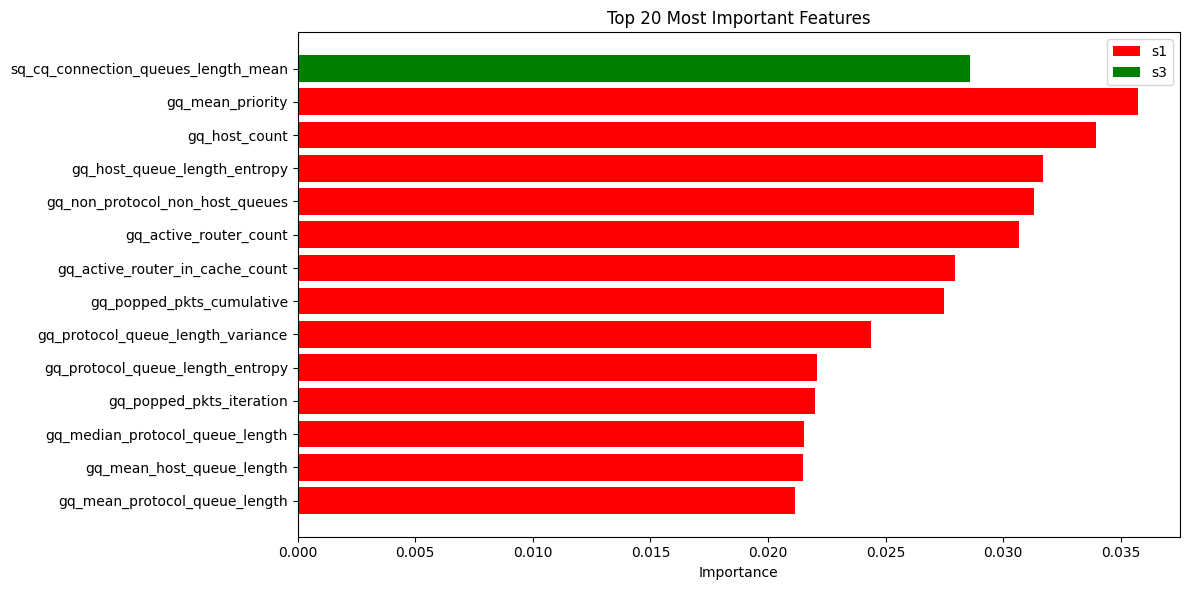

In [ ]:
# reload module to bypass caching
import importlib
importlib.reload(dp)
importlib.reload(dl)

dp.plot_feature_importances(important_features,
                         important_features_values,
                         s1_features,
                         s2_features,
                         s3_features,
                         connection_features)

### SHAP

[05-07-2025 12:09:29] [pypickle.pypickle] [INFO] Loading Pickle file: [/home/hsp252/Development/HSP_IDS/rfc_balanced.pkl]


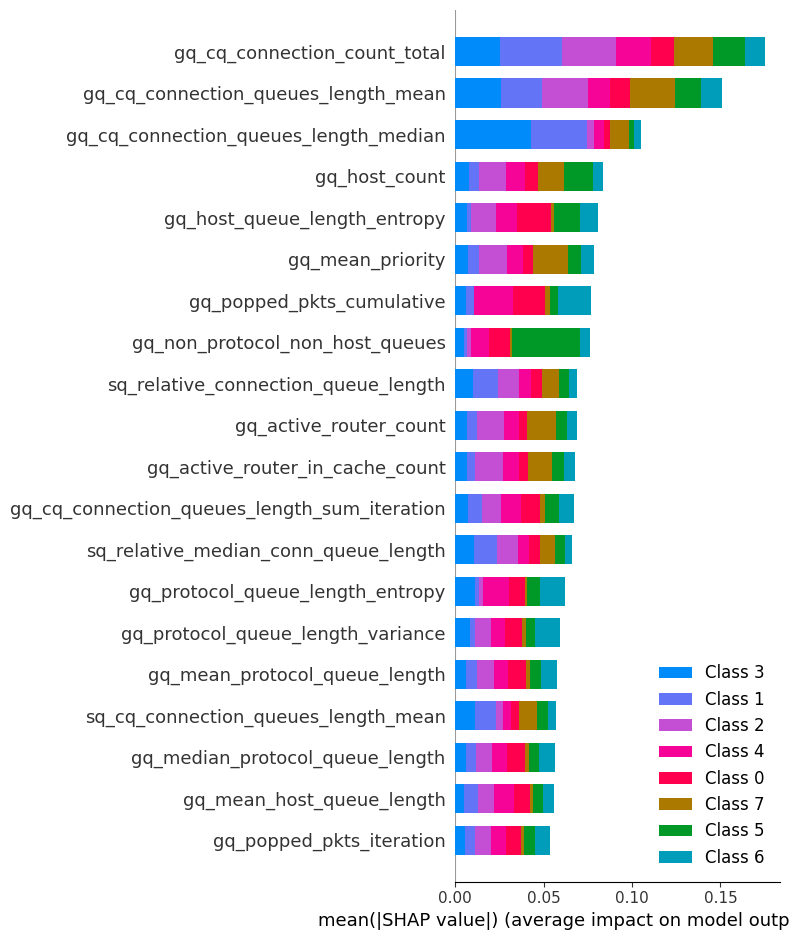

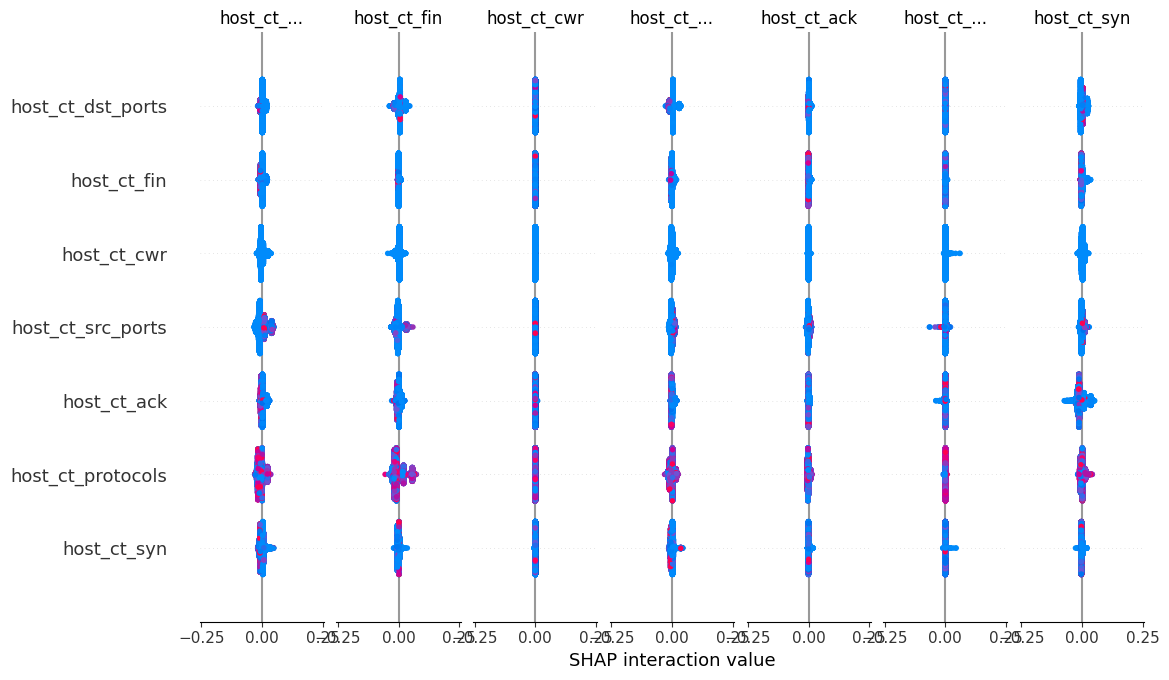

In [ ]:
rfc = dp.pp.load('/home/hsp252/Development/HSP_IDS/rfc_balanced.pkl')
test_fvs, test_labels = dp.get_fvs_from_parquet(parquet_paths=parquet_paths,
                                                NR_ELEMENTS=2000,
                                                attack_types=attack_types,
                                                all_samples=False)

explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(test_fvs)

shap.summary_plot(shap_values, test_fvs, plot_type="bar")
shap.summary_plot(shap_values, test_fvs)

### Test without certain features

[11-07-2025 13:55:47] [pypickle.pypickle] [INFO] Pickle file saved: [/home/hsp252/Development/HSP_IDS/rfc_without_s1.pkl]


saved data
Excluded features for training: s1_features
Accuracy from training: 0.9967855555175598
Accuracy from testing:
0.9961875
Confusion Matrix from testing:
[[1998    0    1    1    0    0    0    0]
 [   0 2000    0    0    0    0    0    0]
 [   0    0 1990    6    0    0    4    0]
 [   0    0    0 1997    0    0    2    1]
 [   0    0    0    0 2000    0    0    0]
 [   2    0    0    0    0 1998    0    0]
 [   0    0    2   27    6    0 1964    1]
 [   0    0    1    5    0    0    2 1992]]



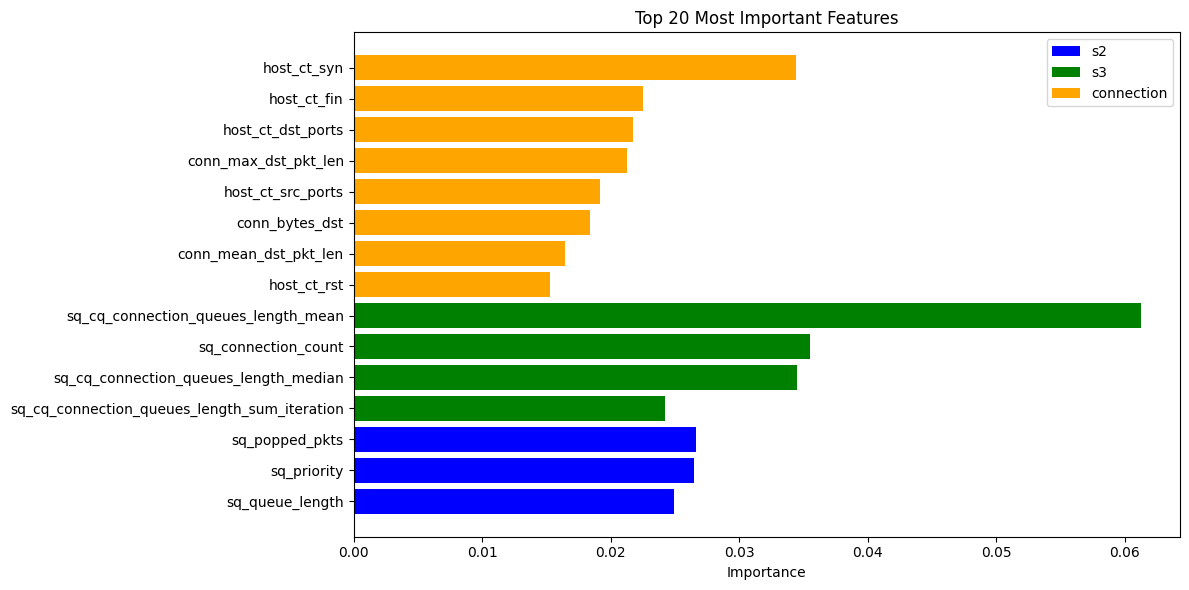

[11-07-2025 14:10:45] [pypickle.pypickle] [INFO] Pickle file saved: [/home/hsp252/Development/HSP_IDS/rfc_without_s1.pkl]


saved data
Excluded features for training: s1_features, s2_features
Accuracy from training: 0.9959477481790514
Accuracy from testing:
0.9951875
Confusion Matrix from testing:
[[1996    0    2    0    0    2    0    0]
 [   0 2000    0    0    0    0    0    0]
 [   0    0 1984    9    0    1    6    0]
 [   0    0    0 1997    2    0    0    1]
 [   0    0    0    1 1999    0    0    0]
 [   1    0    3    1    0 1995    0    0]
 [   0    0    2   31    3    0 1963    1]
 [   0    0    0   10    0    0    1 1989]]



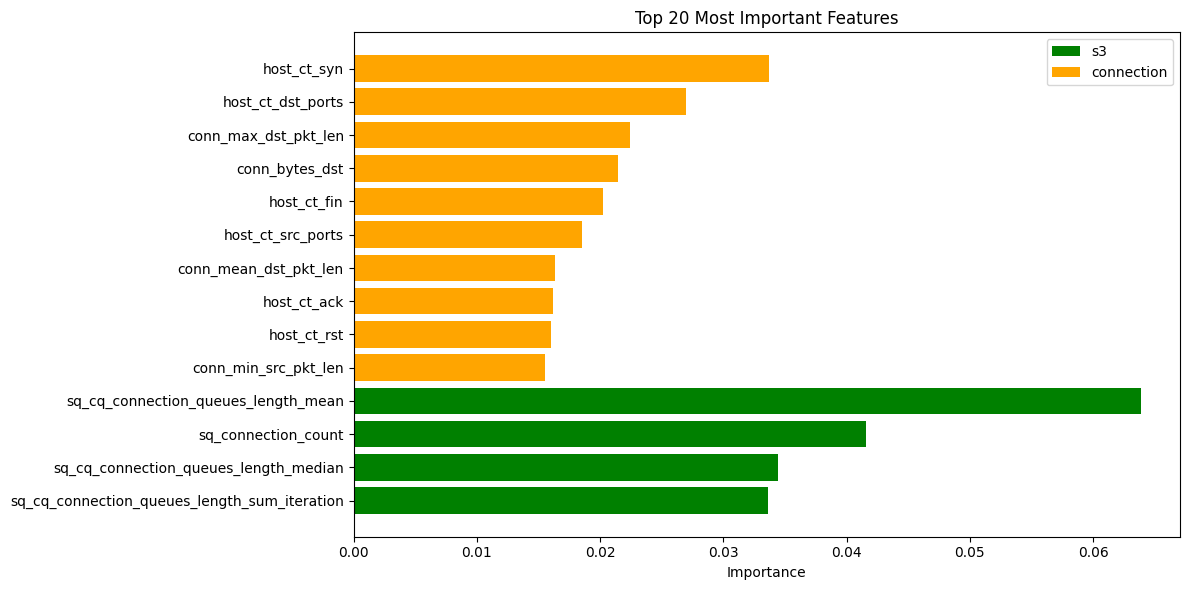

[11-07-2025 14:25:50] [pypickle.pypickle] [INFO] Pickle file saved: [/home/hsp252/Development/HSP_IDS/rfc_without_s1.pkl]


saved data
Excluded features for training: s1_features, s2_features, s3_features
Accuracy from training: 0.9925281263892214
Accuracy from testing:
0.993
Confusion Matrix from testing:
[[1994    0    6    0    0    0    0    0]
 [   0 1998    2    0    0    0    0    0]
 [   2    2 1973   16    1    1    3    2]
 [   0    2    0 1986    1    0    9    2]
 [   0    0    0    0 2000    0    0    0]
 [   2    0    3    1    0 1993    1    0]
 [   2    0    2   32    7    1 1955    1]
 [   0    0    1   10    0    0    0 1989]]



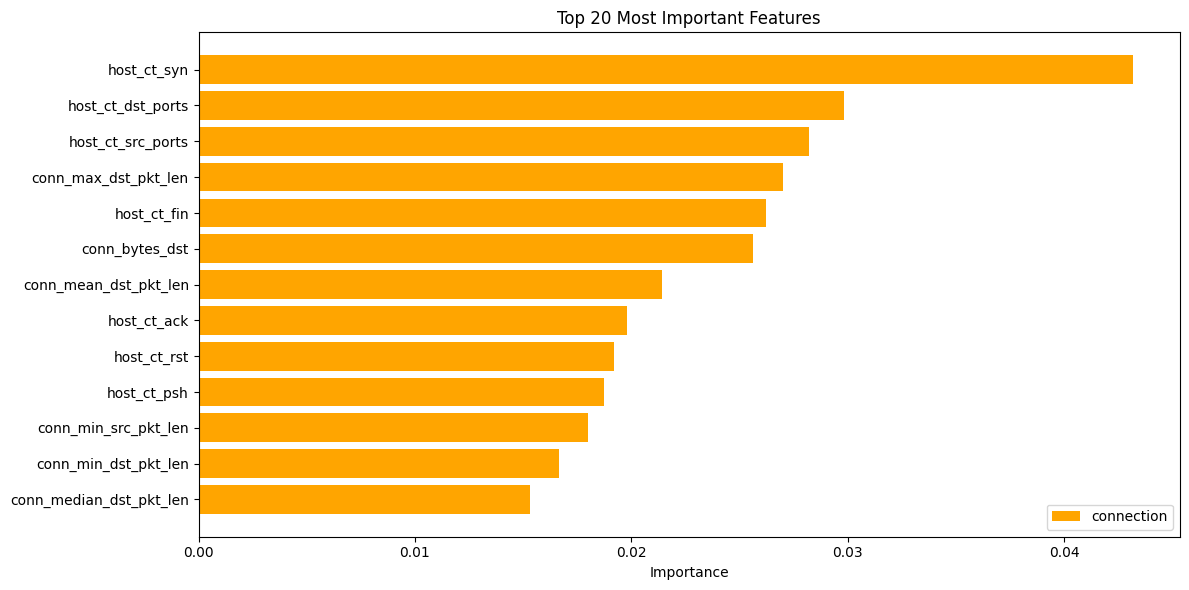

In [ ]:
for x in range(3):

    # exclude features
    all_features = [s1_features, s2_features, s3_features]
    all_features_names = ['s1_features', 's2_features', 's3_features']
    excluded_features = [f for features in all_features[:x+1] for f in features]

    # train
    train_fvs, train_labels = dp.get_fvs_from_parquet(parquet_paths=parquet_paths,
                                                    NR_ELEMENTS=NR_MIN_ELEMENTS_IN_ALL_FILES,
                                                    attack_types=attack_types,
                                                    all_samples=False)

    train_fvs = train_fvs.loc[:, ~train_fvs.columns.isin(excluded_features)]

    best_rfc, best_params_before, predictions, accuracy, feature_importances = dl.rfc(train_fvs, train_labels)
    dl.save_to_pickle(best_rfc, '/home/hsp252/Development/HSP_IDS/rfc_without.pkl')
    print(f"Excluded features for training: {', '.join(all_features_names[:x+1])}")
    print(f"Accuracy from training: {accuracy}")

    # get important features from training
    feature_importance_df = dp.pd.DataFrame({'feature': train_fvs.columns, 'importance': feature_importances})
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
    important_features = feature_importance_df['feature'][:20][::-1].to_numpy()
    important_features_values = feature_importance_df['importance'][:20][::-1].to_numpy()

    # test
    test_fvs, test_labels = dp.get_fvs_from_parquet(parquet_paths=parquet_paths,
                                                            NR_ELEMENTS=2000,
                                                            attack_types=attack_types,
                                                            all_samples=False)
    test_fvs = test_fvs.loc[:, ~test_fvs.columns.isin(excluded_features)]

    test_predictions = best_rfc.predict(test_fvs)

    test_accuracy = dl.accuracy_score(test_labels, test_predictions)
    test_confusion_matrix = dl.confusion_matrix(labels=attack_types, y_true=test_labels, y_pred=test_predictions)

    print(f"Accuracy from testing:{test_accuracy}")
    print(f"Confusion Matrix from testing:\n{test_confusion_matrix}\n")

    # plot feature importances
    dp.plot_feature_importances(important_features,
                                important_features_values,
                                s1_features,
                                s2_features,
                                s3_features,
                                connection_features)

### Test with only s1 features, gradually less

In [25]:
# train on s1 features
train_fvs, train_labels = dp.get_fvs_from_parquet(parquet_paths=parquet_paths,
                                                NR_ELEMENTS=NR_MIN_ELEMENTS_IN_ALL_FILES,
                                                attack_types=attack_types,
                                                all_samples=False)

train_fvs = train_fvs[s1_features]

best_rfc, best_params_before, predictions, accuracy, feature_importances = dl.rfc(train_fvs, train_labels)

# get important features from training
feature_importance_df = dp.pd.DataFrame({'feature': train_fvs.columns, 'importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
important_features = feature_importance_df['feature'][:20][::-1].to_numpy()
important_features_values = feature_importance_df['importance'][:20][::-1].to_numpy()

important_features_original = important_features

for feature in important_features_original:

    # remove next important feature from s1
    removed_feature = important_features[0]
    important_features = dp.np.delete(important_features, 0)
    if important_features.size < 1:
        break
    print(f"removed feature {removed_feature}")

    # train
    train_fvs, train_labels = dp.get_fvs_from_parquet(parquet_paths=parquet_paths,
                                                    NR_ELEMENTS=NR_MIN_ELEMENTS_IN_ALL_FILES,
                                                    attack_types=attack_types,
                                                    all_samples=False)

    train_fvs = train_fvs[important_features]

    best_rfc, best_params_before, predictions, accuracy, feature_importances = dl.rfc(train_fvs, train_labels)
    #dl.save_to_pickle(best_rfc, '/home/hsp252/Development/HSP_IDS/rfc_s1_only.pkl')
    print(f"Accuracy from training: {accuracy}")

    # test
    test_fvs, test_labels = dp.get_fvs_from_parquet(parquet_paths=parquet_paths,
                                                            NR_ELEMENTS=2000,
                                                            attack_types=attack_types,
                                                            all_samples=False)
    test_fvs = test_fvs[important_features]

    test_predictions = best_rfc.predict(test_fvs)

    test_accuracy = dl.accuracy_score(test_labels, test_predictions)

    print(f"Accuracy from testing:{test_accuracy}\n")

removed feature gq_mean_queue_length
Accuracy from training: 0.9999145094552543
Accuracy from testing:0.9999375

removed feature gq_median_host_queue_length
Accuracy from training: 0.9999145094552543
Accuracy from testing:0.99975

removed feature gq_mean_host_queue_length
Accuracy from training: 0.9999316075642034
Accuracy from testing:0.99975

removed feature gq_median_protocol_queue_length
Accuracy from training: 0.9999316075642034
Accuracy from testing:0.999875

removed feature gq_mean_protocol_queue_length
Accuracy from training: 0.9998290189105085
Accuracy from testing:0.9999375

removed feature gq_protocol_queue_length_variance
Accuracy from training: 0.9999487056731525
Accuracy from testing:0.9999375

removed feature gq_host_queue_length_variance
Accuracy from training: 0.999897411346305
Accuracy from testing:0.999875

removed feature gq_protocol_queue_length_entropy
Accuracy from training: 0.9998290189105085
Accuracy from testing:0.9999375

removed feature gq_popped_pkts_iterat

## Single Attack Type 

### Accuracy Test

In [ ]:
# test rfc on single attack data
rfc = dp.pp.load('/home/hsp252/Development/HSP_IDS/rfc_balanced.pkl')

for i, attack_type_path in enumerate(parquet_paths):
    print(attack_types[i])
    accuracies = []
    min_accuracy = 1.0

    for x in range(100):
        test_fvs, test_labels = dp.get_fvs_from_parquet(parquet_paths=[attack_type_path],
                                                        NR_ELEMENTS=2000,
                                                        attack_types=[attack_types[i]],
                                                        all_samples=True)

        test_predictions = rfc.predict(test_fvs)
        test_accuracy = dl.accuracy_score(test_labels, test_predictions)

        accuracies.append(test_accuracy)
        if test_accuracy < min_accuracy:
            min_accuracy = test_accuracy

        # test_confusion_matrix = dl.confusion_matrix(labels=attack_types, y_true=test_labels, y_pred=test_predictions)

        # print(f"{attack_types[i]}")
        # print(f"accurracy: {test_accuracy}")
        # print(f"confusion matrix: \n{test_confusion_matrix}\n")
    average_accuracy = sum(accuracies) / len(accuracies)
    print(f"Average Accuracy: {average_accuracy}")
    print(f"Minimal Accuracy: {min_accuracy}\n")

[autoreload of data_analysis.data_learning failed: Traceback (most recent call last):
  File "/opt/Miniconda/envs/jannis_env/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 283, in check
    superreload(m, reload, self.old_objects)
  File "/opt/Miniconda/envs/jannis_env/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 483, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/opt/Miniconda/envs/jannis_env/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 936, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1074, in get_code
  File "<frozen importlib._bootstrap_external>", line 1004, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/hsp252/Development/HSP_IDS/data_analysis/data_learning

ddos


RuntimeError: Query interrupted

: 

### F1 Score Test

In [ ]:
# test rfc on single attack data
rfc = dp.pp.load('/home/hsp252/Development/HSP_IDS/rfc_balanced.pkl')

for i, attack_type_path in enumerate(parquet_paths):
    print(attack_types[i])

    f1_scores = []
    min_f1_score = 1.0

    for x in range(100):
        test_fvs, test_labels = dp.get_fvs_from_parquet(parquet_paths=parquet_paths,
                                                        NR_ELEMENTS=2000,
                                                        attack_types=attack_types,
                                                        all_samples=False)
        
        test_labels = test_labels['attack_type'].to_list()
        test_labels = [f'not {attack_types[i]}' if x != f'{attack_types[i]}' else x for x in test_labels] # make it
        # binary class problem

        test_predictions = rfc.predict(test_fvs)
        test_predictions = [f'not {attack_types[i]}' if x != f'{attack_types[i]}' else x for x in test_predictions] # make it
        # binary class problem

        f1_score = dl.f1_score(test_labels, test_predictions, average='binary', pos_label=f'{attack_types[i]}')

        f1_scores.append(f1_score)
        if f1_score < min_f1_score:
            min_f1_score = f1_score
            
    average_f1_score = sum(f1_scores) / len(f1_scores)
    print(f"Average F1 Score: {average_f1_score}")
    print(f"Minimal F1 Score: {min_f1_score}\n")

[09-07-2025 09:06:33] [pypickle.pypickle] [INFO] Loading Pickle file: [/home/hsp252/Development/HSP_IDS/rfc_balanced.pkl]


ddos
Average F1 Score: 0.9998349874849982
Minimal F1 Score: 0.9992498124531133

dos
Average F1 Score: 1.0
Minimal F1 Score: 1.0

injection
Average F1 Score: 0.9995022692065829
Minimal F1 Score: 0.9984984984984985

mitm
Average F1 Score: 0.9995253434263205
Minimal F1 Score: 0.998003992015968

runsomware
Average F1 Score: 1.0
Minimal F1 Score: 1.0

scanning
Average F1 Score: 0.999879996239999
Minimal F1 Score: 0.9992501874531368

backdoor
Average F1 Score: 0.999307506748904
Minimal F1 Score: 0.9982495623905977

normal
Average F1 Score: 0.9997449136971552
Minimal F1 Score: 0.9987490617963473



# Anomaly Detection

## Isolation Forest

In [ ]:
# NOT FINISHED YET!!
# get 90% normal samples
fvs, labels = dp.get_fvs_from_parquet(parquet_paths=[parquet_paths[7]],
                                    NR_ELEMENTS=700000,
                                    attack_types=attack_types[7],
                                    all_samples=False)

# get 10% attack samples accumulated
for i, path in enumerate(parquet_paths[1:], 1):
    fvs_local, labels_local = dp.get_fvs_from_parquet([path],
                                                    10000,
                                                    attack_types[i],
                                                    all_samples=False)
    fvs = dp.pd.concat([fvs, fvs_local])
    labels = dp.pd.concat([labels, labels_local])
print("fetched data")

# create isolation forest and save
i_forest = dl.i_forest(fvs, labels)
dl.save_to_pickle(i_forest, '/home/hsp252/Development/HSP_IDS/i_forest.pkl')

fetched data
1
256667


/opt/Miniconda/envs/jannis_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/Miniconda/envs/jannis_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/Miniconda/envs/jannis_env/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/Miniconda/envs/jannis_env/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
      

1
513333


/opt/Miniconda/envs/jannis_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/Miniconda/envs/jannis_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/Miniconda/envs/jannis_env/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/Miniconda/envs/jannis_env/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
      

1
256667


/opt/Miniconda/envs/jannis_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/Miniconda/envs/jannis_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/Miniconda/envs/jannis_env/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/Miniconda/envs/jannis_env/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
      

1
513333


/opt/Miniconda/envs/jannis_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/Miniconda/envs/jannis_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/Miniconda/envs/jannis_env/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/Miniconda/envs/jannis_env/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
      

KeyboardInterrupt: 

# TODO

In [ ]:
#( TODO: try Isolation Forest (this is unsupervised):)
# ( use GridSearch, maybe one forest per feature (very computational expensive), )
# TODO: redo tests with less and less features of connection_features -> explanation and analysis of current results
# TODO: tidy up py-files